### Making the necessary imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import copy 
import tensorflow as tf
import seaborn as sns

2023-12-24 21:37:44.988091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data pre-processing:

In [2]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snowfall', 'functional']
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis = 1)
df.columns = dataset_cols

In [3]:
df['functional'] = (df.functional == 'Yes').astype(int)

In [4]:
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis = 1)

Let us plot the various parameters against the bike count and see which ones are relevant for our purposes. We can drop the rest.

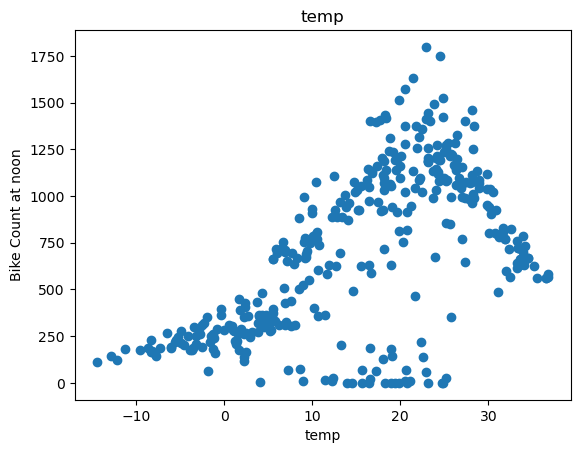

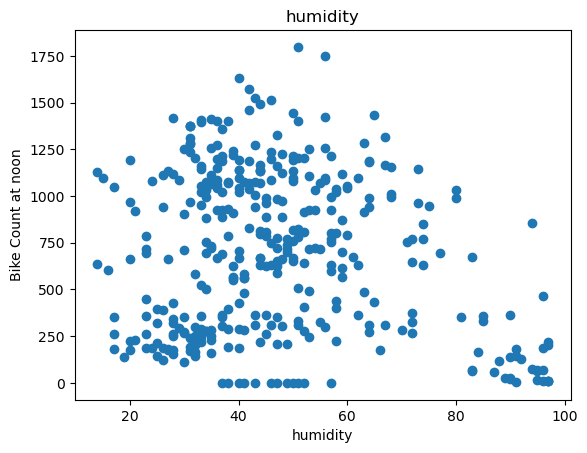

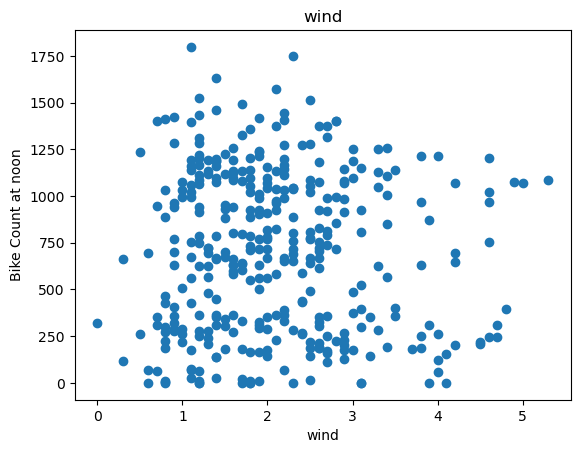

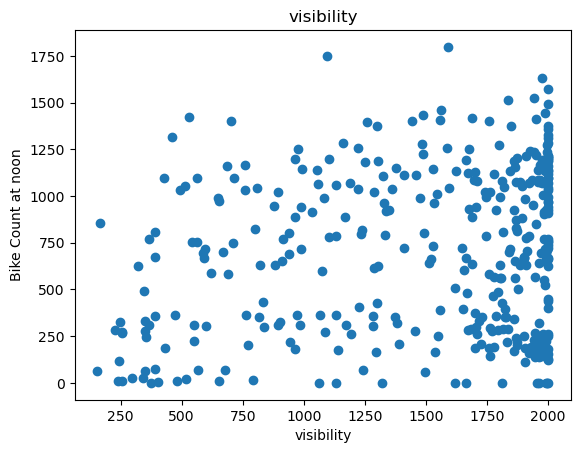

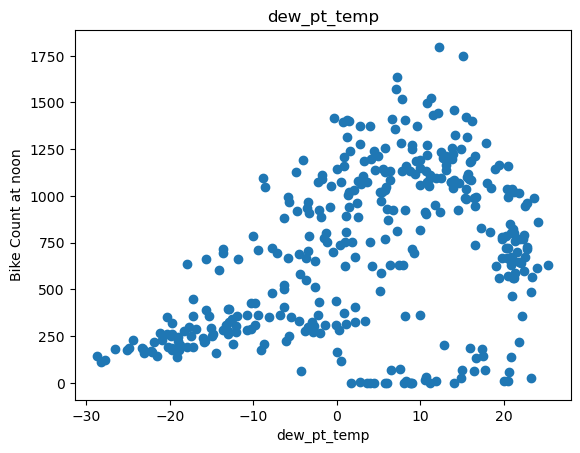

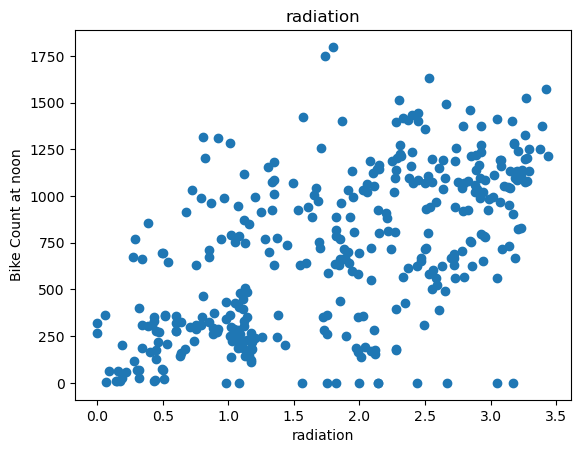

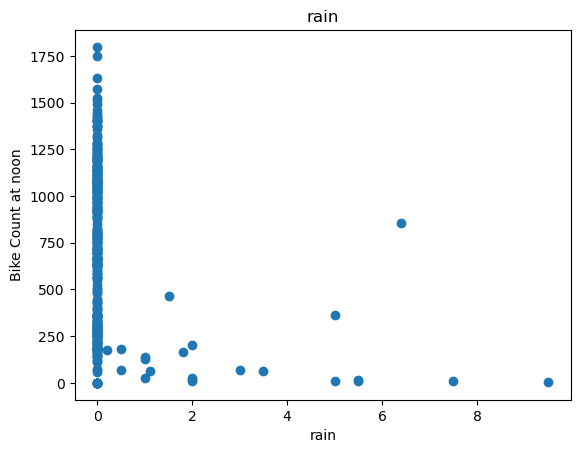

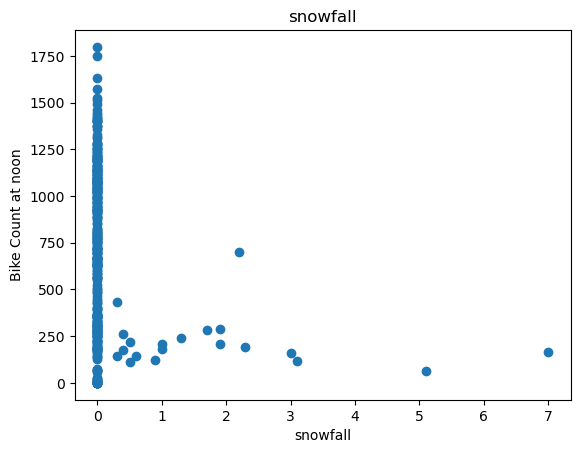

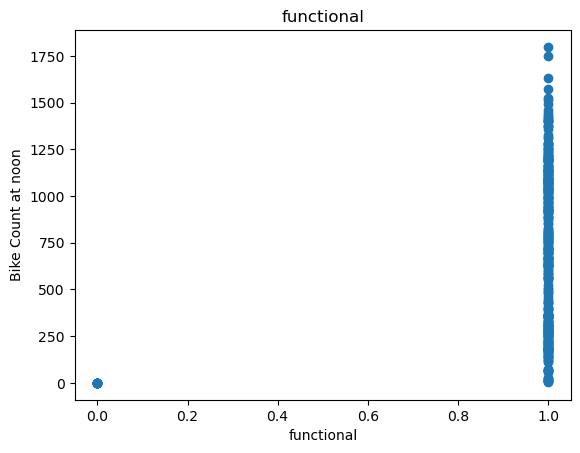

In [5]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at noon')
    plt.xlabel(label)
    plt.show()

In [6]:
df = df.drop(['wind', 'visibility', 'functional'], axis = 1)

### Building the training, validation and test datasets:

In [7]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])

In [8]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = [[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    Y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,Y))
    return data, X, Y

## Linear Regression:

First, we are only going to use one parameter (temperature) for linear regression. Then we are going to include other parameters for multiple linear regression.

In [9]:
# These are the training, validation and test datasets for just the temperature.
_, x_train_temp, y_train_temp = get_xy( train, "bike_count", x_labels = ['temp'])
_, x_val_temp, y_val_temp = get_xy( val, "bike_count", x_labels = ['temp'])
_, x_test_temp, y_test_temp = get_xy( test, "bike_count", x_labels = ['temp'])

In [10]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)
print(temp_reg.coef_, temp_reg.intercept_)
print('\n')
# The higher this 'score' number, the higher the correlation between the two variables.
# This number is the R^2 value, or the Coefficient of determination.
print(temp_reg.score(x_test_temp, y_test_temp))

[[20.24531247]] [397.78375829]


0.3891828729216459


2023-12-24 21:38:22.523723: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


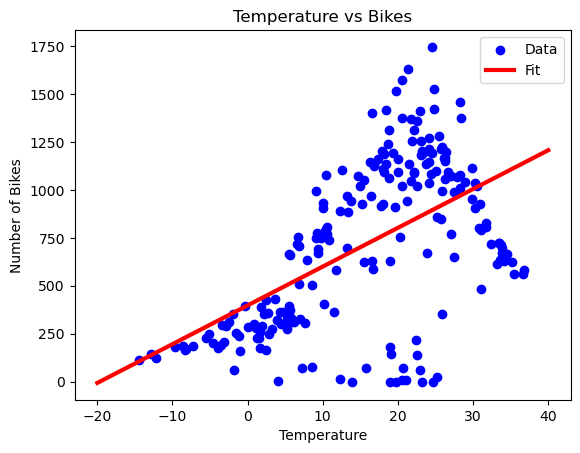

In [11]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label = 'Fit', color = 'red', lw = 3)
plt.legend()
plt.title("Temperature vs Bikes")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()


## Multiple Linear Regression:

In [12]:
_, x_train, y_train = get_xy( train, "bike_count", x_labels = df.columns[1:])
_, x_val, y_val = get_xy( val, "bike_count", x_labels = df.columns[1:])
_, x_test, y_test = get_xy( test, "bike_count", x_labels = df.columns[1:])

In [13]:
all_reg = LinearRegression()
all_reg.fit(x_train, y_train)
print(all_reg.coef_, all_reg.intercept_)
print('\n')
print(all_reg.score(x_test, y_test))

[[-14.02921368 -11.27861719  31.45301269 145.17517698 -21.45027405
  -18.23179567]] [1107.47370381]


0.5936841995568389


In [14]:
y_pred_mlr = all_reg.predict(x_test)

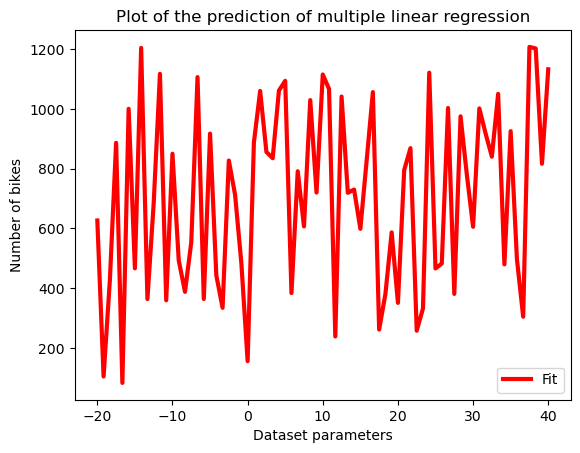

In [24]:
# plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
# x = tf.linspace(-20,40,73)
plt.plot(x, y_pred_mlr, label = 'Fit', color = 'red', lw = 3 )
plt.legend()
plt.title("Plot of the prediction of multiple linear regression")
plt.ylabel("Number of bikes")
plt.xlabel("Dataset parameters")
plt.show()


## Regression with Neural Net:

#### Linear regression while using only temperature:

In [31]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

In [77]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(x_train_temp.reshape(-1))


In [78]:
# With just one layer and no activation function, we have created a linear model.
temp_nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(1)
])

In [79]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [80]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val_temp, y_val_temp)
)

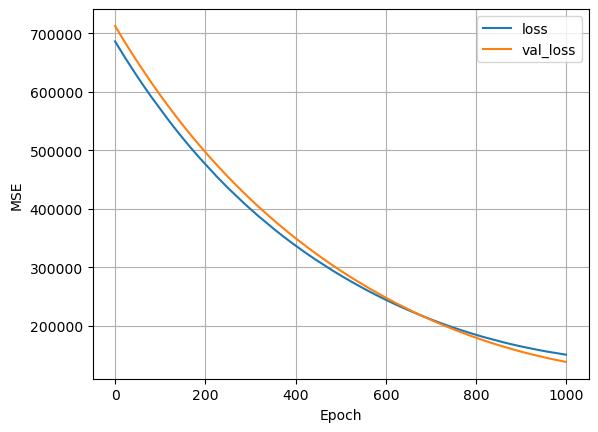

In [81]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


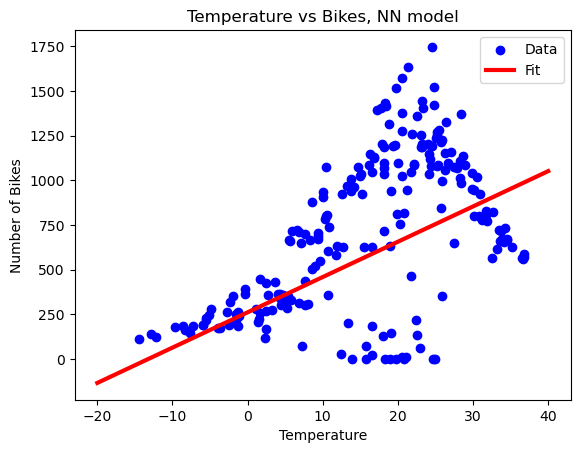

In [82]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = 'Fit', color = 'red', lw = 3)
plt.legend()
plt.title("Temperature vs Bikes, NN model")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()


#### NN linear regression model with all variables:

In [36]:
normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
normalizer.adapt(x_train)


In [37]:
nn_model = tf.keras.Sequential([
    normalizer, 
    tf.keras.layers.Dense(1)
])

In [38]:
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [39]:
history = nn_model.fit(
    x_train, y_train,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val, y_val)
)

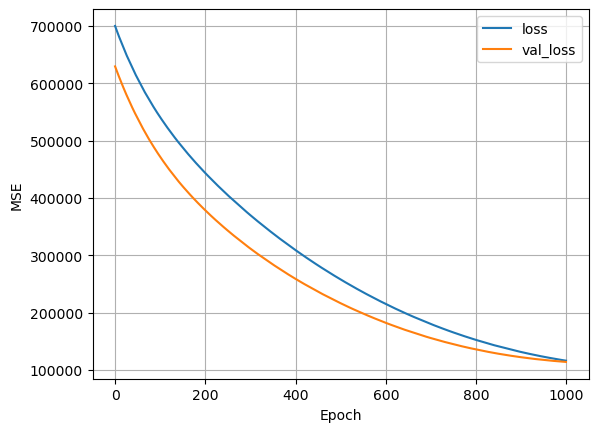

In [40]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


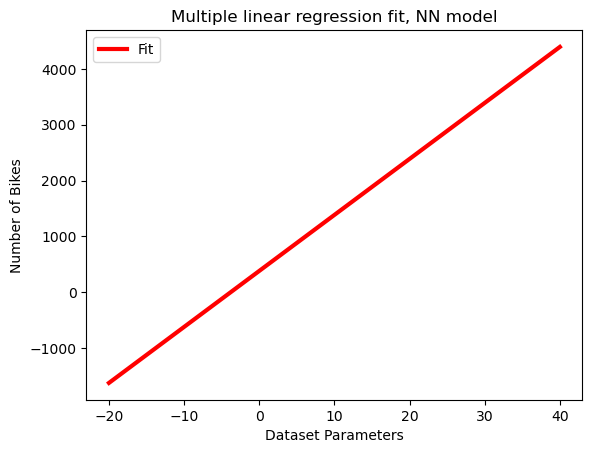

In [42]:
# plt.scatter(x_train, y_train, label = "Data", color = "blue")
x = tf.linspace(-20,40,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label = 'Fit', color = 'red', lw = 3)
plt.legend()
plt.title("Multiple linear regression fit, NN model")
plt.ylabel("Number of Bikes")
plt.xlabel("Dataset Parameters")
plt.show()


#### Using a proper, multi-layered Neural Net:

In [98]:
nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1,)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

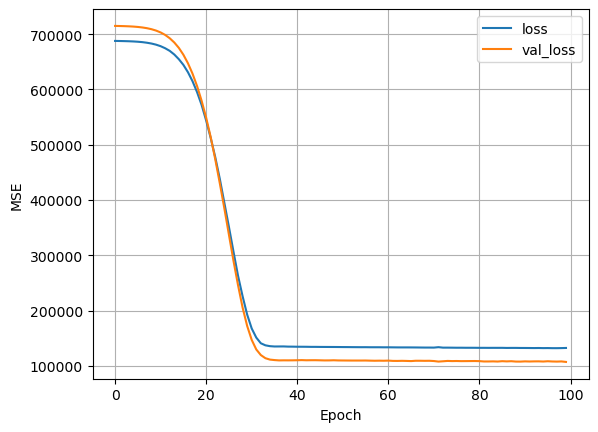

In [99]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data = (x_val_temp, y_val_temp),
    verbose = 0,
    epochs = 100
)
plot_loss(history)

4/4 [==============================] - 0s 80ms/step


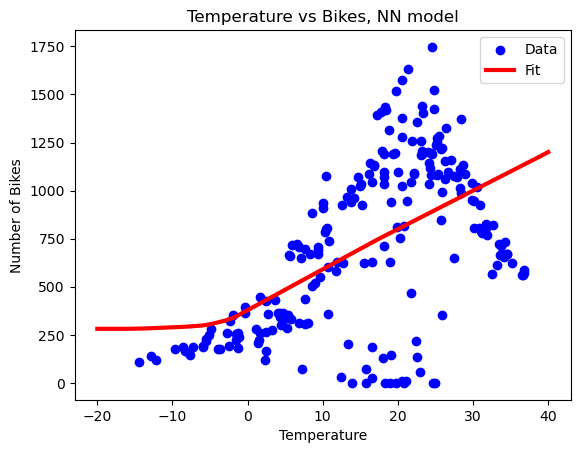

In [100]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20,40,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label = 'Fit', color = 'red', lw = 3)
plt.legend()
plt.title("Temperature vs Bikes, NN model")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()


#### Neural Net with all data:

In [117]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
all_normalizer.adapt(x_train_temp)


In [118]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1,)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [119]:
history = nn_model.fit(
    x_train, y_train,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val, y_val)
)

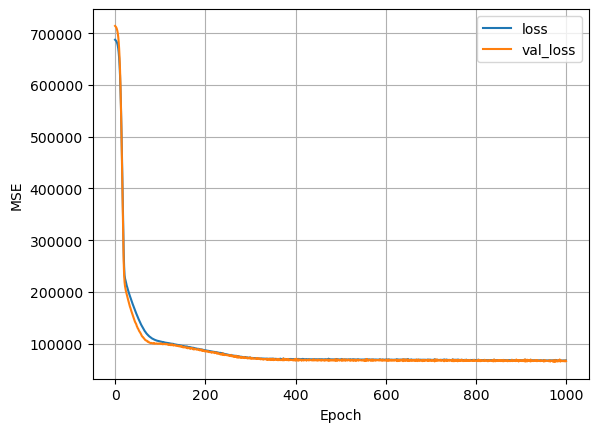

In [120]:
plot_loss(history)

In [121]:
y_pred_nn = nn_model.predict(x_test)

3/3 [==============================] - 0s 21ms/step


#### Mean Squared error for Neural Net and multiple linear regressor:

In [122]:
def MSE(y_predict, y_real):
    return (np.square(y_predict - y_real)).mean()

In [123]:
print(MSE(y_pred_mlr, y_test))
print("\n")
print(MSE(y_pred_nn, y_test))

78925.30276611549


66258.68432039938


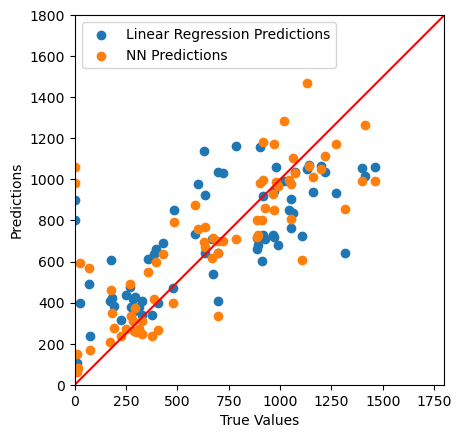

In [126]:
ax = plt.axes(aspect = 'equal')
plt.scatter(y_test, y_pred_mlr, label = 'Linear Regression Predictions')
plt.scatter(y_test, y_pred_nn, label = 'NN Predictions')
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = (0,1800)
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims,lims, c = "red")